In [6]:
import matplotlib.pyplot as plt
import PIL
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import pathlib

Data Preparation

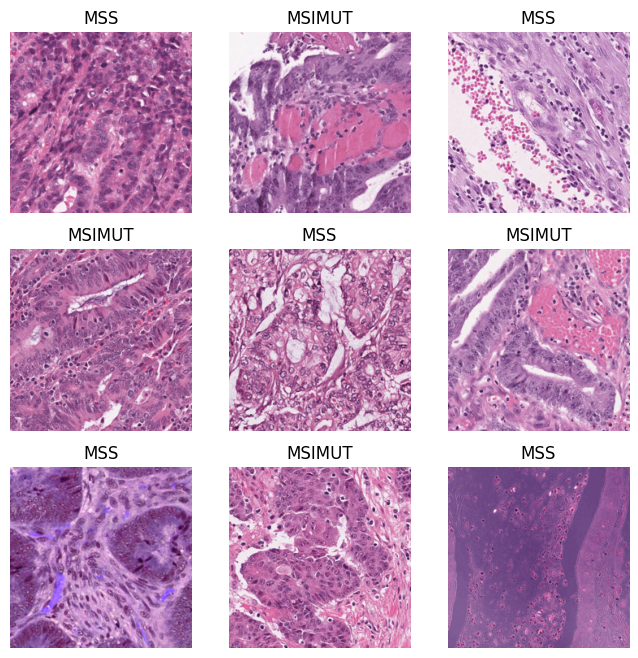

In [7]:
# Path to dataset
training_path = pathlib.Path("../dataset/training/")
mss = list(training_path.glob('MSS/*'))
msi = list(training_path.glob('MSIMUT/*'))

#Show examples of original images
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(8,8))

for i, ax in enumerate(axes.flat):
    if(i % 2 == 0):
        img = PIL.Image.open(str(mss[i]))
        ax.imshow(img)
        ax.set_title("MSS")
        ax.axis('off')
    else:
        img = PIL.Image.open(str(msi[i]))
        ax.imshow(img)
        ax.set_title("MSIMUT")
        ax.axis('off')

# Show the grid of images
plt.show()

In [8]:
print(f"Number of MSIMUT Samples: {len(msi)}")
print(f"Number of MSS Samples: {len(mss)}")

Number of MSIMUT Samples: 30000
Number of MSS Samples: 30000


In [4]:
#Check if all images have the same resolution
resolution = set()
for image_file in msi:
    with PIL.Image.open(image_file) as img:
        resolution.add(img.size)
for image_file in mss:
    with PIL.Image.open(image_file) as img:
        resolution.add(img.size)
if len(resolution) == 1:
    print("All images have the same resolution:", resolution.pop())
else:
    print("Images have different resolutions:", resolution)

All images have the same resolution: (224, 224)


In [5]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
batch=32
img_height,img_width=224,224

#Data preprocessing
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input, #Preprocess input according to network standards
    validation_split=0.2,) #Split data between validation and training set 


train_ds = train_datagen.flow_from_directory(
    directory=training_path,
    target_size=(img_height, img_width),
    subset="training",
    batch_size=batch,
    class_mode='binary',
    seed=666
)

val_ds = train_datagen.flow_from_directory(
    directory=training_path,
    target_size=(img_height, img_width),
    subset="validation",
    batch_size=batch,
    class_mode='binary',
    seed=666
)

Found 48000 images belonging to 2 classes.
Found 12000 images belonging to 2 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


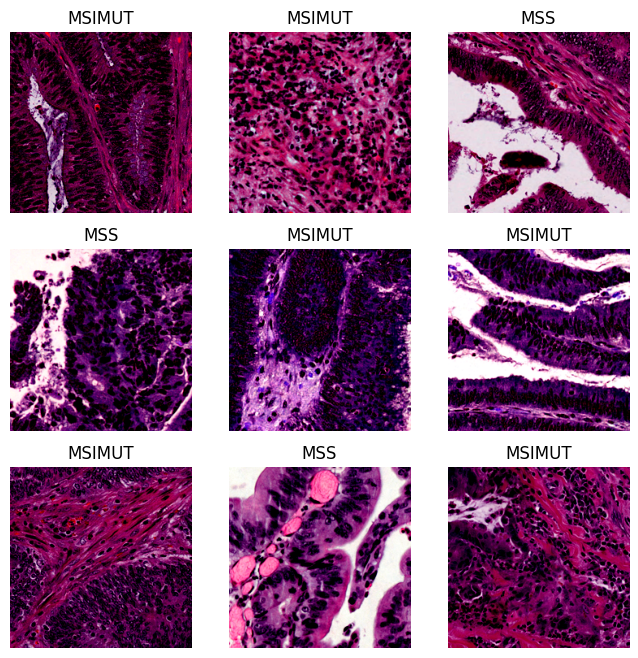

In [9]:
#Images after Preprocessing
images, labels = next(train_ds)

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(8,8))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i])
    if(labels[i]==1):
        ax.set_title("MSS")
    else:
        ax.set_title("MSIMUT")
    ax.axis('off')
plt.show()

Classifier Training

In [4]:
hybrid_model = Sequential()

pretrained_model= tf.keras.applications.InceptionResNetV2(include_top=False,
                   input_shape=(224,224,3),
                   classes=2,
                   weights='imagenet')
pretrained_model.trainable = False
# Create new model on top
inputs = keras.Input(shape=(224, 224, 3))

x = pretrained_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.Dropout(0.6)(x)
x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.Dropout(0.6)(x)
outputs = keras.layers.Dense(1, activation='sigmoid')(x)
hybrid_model = keras.Model(inputs, outputs)

hybrid_model.summary()

219055592/219055592 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 inception_resnet_v2 (Functi  (None, 5, 5, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              1573888   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                            

In [5]:
hybrid_model.compile(optimizer=keras.optimizers.Adam(),
                     loss=keras.losses.BinaryCrossentropy(),
                     metrics=[keras.metrics.BinaryAccuracy()])

In [6]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
epochs=200
history = hybrid_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[early_stopping]
)

Epoch 1/200
1500/1500 [==============================] - 734s 476ms/step - loss: 0.6919 - binary_accuracy: 0.5907 - val_loss: 0.6229 - val_binary_accuracy: 0.6606
Epoch 2/200
1500/1500 [==============================] - 372s 248ms/step - loss: 0.6383 - binary_accuracy: 0.6269 - val_loss: 0.6083 - val_binary_accuracy: 0.6797
Epoch 3/200
1500/1500 [==============================] - 372s 248ms/step - loss: 0.6257 - binary_accuracy: 0.6467 - val_loss: 0.5993 - val_binary_accuracy: 0.6963
Epoch 4/200
1500/1500 [==============================] - 335s 223ms/step - loss: 0.6143 - binary_accuracy: 0.6600 - val_loss: 0.5978 - val_binary_accuracy: 0.6924
Epoch 5/200
1500/1500 [==============================] - 335s 223ms/step - loss: 0.6068 - binary_accuracy: 0.6636 - val_loss: 0.5803 - val_binary_accuracy: 0.7057
Epoch 6/200
1500/1500 [==============================] - 335s 223ms/step - loss: 0.6020 - binary_accuracy: 0.6694 - val_loss: 0.5754 - val_binary_accuracy: 0.7132
Epoch 7/200
1500/1500 

In [7]:
hybrid_model.save('/kaggle/working/hybrid_no_fine_tune_model_final', save_format="h5")

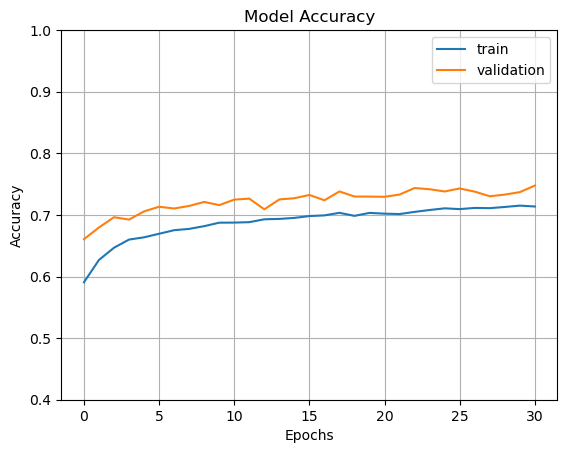

In [8]:
fig1 = plt.gcf()
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

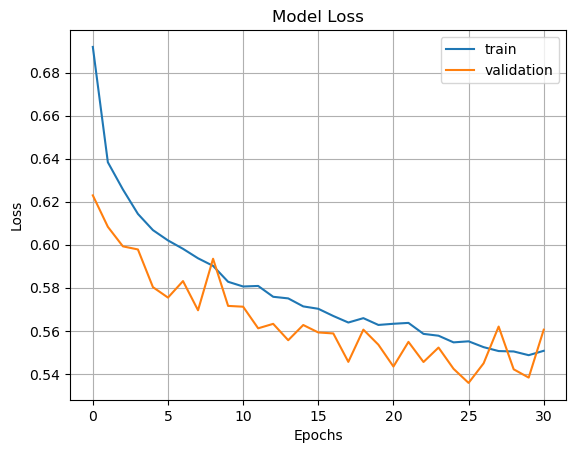

In [9]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

Fine Tuning

In [10]:
hybrid_model.trainable = True
hybrid_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 inception_resnet_v2 (Functi  (None, 5, 5, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              1573888   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800

In [11]:
hybrid_model.compile(
    optimizer=keras.optimizers.Adam(1e-6),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 200
history_fine_tune = hybrid_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stopping]
    )

Epoch 1/200
1500/1500 [==============================] - 1052s 644ms/step - loss: 0.5264 - binary_accuracy: 0.7315 - val_loss: 0.5144 - val_binary_accuracy: 0.7658
Epoch 2/200
1500/1500 [==============================] - 980s 653ms/step - loss: 0.4931 - binary_accuracy: 0.7575 - val_loss: 0.4990 - val_binary_accuracy: 0.7773
Epoch 3/200
1500/1500 [==============================] - 967s 644ms/step - loss: 0.4671 - binary_accuracy: 0.7725 - val_loss: 0.4762 - val_binary_accuracy: 0.7944
Epoch 4/200
1500/1500 [==============================] - 969s 646ms/step - loss: 0.4450 - binary_accuracy: 0.7894 - val_loss: 0.4614 - val_binary_accuracy: 0.7976
Epoch 5/200
1500/1500 [==============================] - 967s 644ms/step - loss: 0.4221 - binary_accuracy: 0.8036 - val_loss: 0.4444 - val_binary_accuracy: 0.8048
Epoch 6/200
1500/1500 [==============================] - 966s 644ms/step - loss: 0.4003 - binary_accuracy: 0.8170 - val_loss: 0.4306 - val_binary_accuracy: 0.8105
Epoch 7/200
1500/1500

In [12]:
hybrid_model.save('../Feature Extraction models/hybrid_model', save_format="h5")

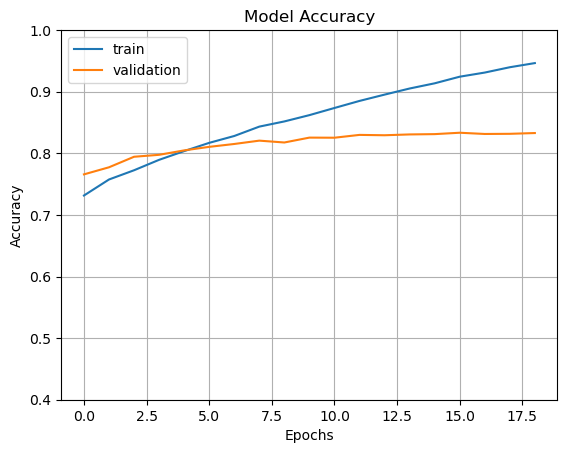

In [13]:
fig1 = plt.gcf()
plt.plot(history_fine_tune.history['binary_accuracy'])
plt.plot(history_fine_tune.history['val_binary_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()
     

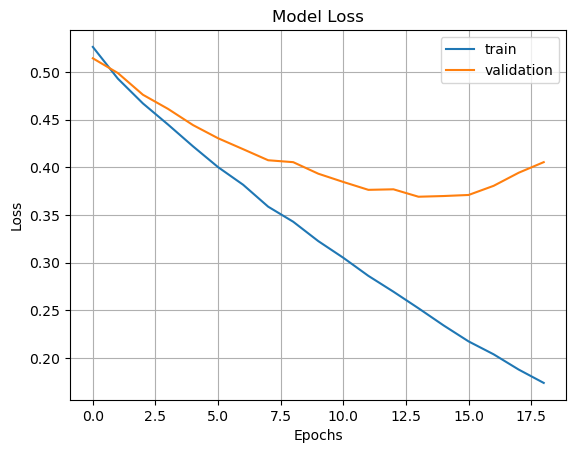

In [14]:
plt.plot(history_fine_tune.history['loss'])
plt.plot(history_fine_tune.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()